# WA5FRF Chirp Experiment Analysis Script

In [1]:
import os
import numpy as np
from numpy import ma
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.dates as mdates

from datetime import datetime
from IPython.display import Audio, display, clear_output
import scipy
from scipy import signal
from scipy.io import wavfile
import pandas as pd
from pydub import AudioSegment
import taglib
import eclipse_calc


%matplotlib inline

c:\Users\alexp\anaconda3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# Sets default style and font parameters for the plots we are making.
mpl.rcParams['font.size']      = 16
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = (12,9)
mpl.rcParams['axes.xmargin']   = 0
mpl.rcParams['axes.ymargin']   = 0.1

In [3]:
def load_wav(fname,normalize=True):
    """    
    Loads a WAV file and returns a DataFrame with the signal
    and the sampling frequency.
    
    Input:
        fname:     Filename of WAV file.
        normalize: If True, normalize signal and convert to floating point.
        
    Returns:
        df: DataFrame containing signal
        fs: Sampling frequency [samples/sec]
    """
    # Load WAV file.
    fs,x0 = wavfile.read(fname)
    
    if normalize:
        x0   = x0/float(np.max(np.abs(x0)))

    # Compute time vector.
    N  = len(x0)             # Number of samples in signal
    k  = np.arange(len(x0))  # Integer time vector
    Ts = 1/fs                # Sampling Period
    t  = k*Ts
    
    df = pd.DataFrame({'time':t,'x':x0})
    df = df.set_index('time')
    
    return df, fs     

In [4]:
def process(filepath):
    x0,fs  = load_wav(filepath)
    
    # Square the signal.
    x1  = x0**2

    # Compute envelope using a rolling max function.
    Tc  = 1.2e-3 # Rolling Max Window [seconds]
    env = x1.rolling(int(Tc*fs),center=True).max()
    env = env.dropna() # Drop NaNs
    
    wp    = 250
    ws    = 1.1*wp

    gpass =  3 # The maximum loss in the passband (dB).
    gstop = 40 # The minimum attenuation in the stopband (dB).
    
    N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
    sos   = signal.butter(N, Wn, 'low', fs=fs, output='sos')

    env_1      = env.copy()
    env_1['x'] = signal.sosfiltfilt(sos,env['x'])

    wp    = 10
    ws    = 0.8*wp

    gpass =  3 # The maximum loss in the passband (dB).
    gstop = 40 # The minimum attenuation in the stopband (dB).

    N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
    sos   = signal.butter(N, Wn, 'high', fs=fs, output='sos')

    env_2      = env_1.copy()
    env_2['x'] = signal.sosfiltfilt(sos,env_1['x'])
    
    return env_2, signal.sosfiltfilt(sos,env_1['x']), fs

In [5]:
def processN5(filepath):
    x0,fs  = load_wav(filepath)
    
    # Square the signal.
    x1  = x0**2

    # Compute envelope using a rolling max function.
    Tc  = 1.2e-3 # Rolling Max Window [seconds]
    env = x1.rolling(int(Tc*fs),center=True).max()
    env = env.dropna() # Drop NaNs
    
    wp    = 250
    ws    = 1.1*wp

    gpass =  3 # The maximum loss in the passband (dB).
    gstop = 40 # The minimum attenuation in the stopband (dB).
    
    N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
    sos   = signal.butter(N, Wn, 'low', fs=fs, output='sos')

    env_1      = env.copy()
    # env_1['x'] = signal.sosfiltfilt(sos,env['x'])

    wp    = 10
    ws    = 0.8*wp

    gpass =  3 # The maximum loss in the passband (dB).
    gstop = 40 # The minimum attenuation in the stopband (dB).

    N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
    sos   = signal.butter(N, Wn, 'high', fs=fs, output='sos')

    env_2      = env_1.copy()
    # env_2['x'] = signal.sosfiltfilt(sos,env_1['x'])
    
    return env_2, signal.sosfiltfilt(sos,env_1['x']), fs



In [6]:
def processAB(filepath):
    x0,fs  = load_wav(filepath)
    
    # Square the signal.
    x1  = x0**2

    # Compute envelope using a rolling max function.
    Tc  = 1.2e-3 # Rolling Max Window [seconds]
    env = x1.rolling(int(Tc*fs),center=True).max()
    env = env.dropna() # Drop NaNs
    
    wp    = 1500*4
    ws    = 1.1*wp

    gpass =  3 # The maximum loss in the passband (dB).
    gstop = 40 # The minimum attenuation in the stopband (dB).
    
    N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
    sos   = signal.butter(N, Wn, 'low', fs=fs, output='sos')

    env_1      = env.copy()
    env_1['x'] = signal.sosfiltfilt(sos,env['x'])

    wp    = 10
    ws    = 0.8*wp

    gpass =  3 # The maximum loss in the passband (dB).
    gstop = 40 # The minimum attenuation in the stopband (dB).

    N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
    sos   = signal.butter(N, Wn, 'high', fs=fs, output='sos')

    env_2      = env_1.copy()
    env_2['x'] = signal.sosfiltfilt(sos,env_1['x'])
    
    return env_2, signal.sosfiltfilt(sos,env_1['x']), fs

In [7]:
def find_max(X,freq,minfreq,maxfreq):
    if maxfreq==0:
        maxfreq=10000
    start = np.argwhere(freq>=minfreq)[0][0]
    end = np.argwhere(freq<=maxfreq)[-1:][0][0]
    maxima = max(X[start:end])
    maximum = np.argwhere(X==maxima)
    maximum = abs(freq[maximum][0])
    return maximum

In [8]:
def new_plot_sig(df,column='x',title=None,tlim=None,flim=None,
                 plot_fft=False, peaktime='', minfreq=0,maxfreq=10000):
   
    x    = df[column]
    tvec = df.index
    Ts   = tvec[1] - tvec[0]
    Fs   =1/Ts

    if tlim is None:
        tlim = (0,np.max(tvec))
    elif tlim is not None:
        tf  = np.logical_and(tvec >= tlim[0],
                                tvec <  tlim[1])
        xt  = x[tf].copy()
        
    han_win = np.hanning(len(xt))
    x_han   = han_win*xt
    nfft    = len(x_han)
    if nfft < 2**16: 
        nfft = 2**16

    X_psd   = np.abs(np.fft.fftshift(np.fft.fft(x_han,n=nfft)*Ts*2))**2
    f       = np.fft.fftshift(np.fft.fftfreq(nfft,Ts))

    if plot_fft==True:
        if maxfreq==0:
            maxfreq=10000
        flim = (0,maxfreq)
        start = np.argwhere(f>=minfreq)[0][0]
        end = np.argwhere(f<=maxfreq)[-1:][0][0]

        maxima = max(X_psd[start:end])
        maximum = np.argwhere(X_psd==maxima)
        maximum = abs(f[maximum][0])
        peaktime=str(peaktime[0])+'_'+str(peaktime[1]+1)

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(2,1,1)
        bx = fig.add_subplot(2,1,2)
        bx.plot(tvec,x)
        bx.set_xlim(tlim)

        ax.plot(f,X_psd)
        ax.plot([maximum,maximum],[0,max(X_psd)],linewidth=2)
        ax.plot([minfreq,minfreq],[0,max(X_psd)],linewidth=3, color='black')

        ax.plot([0,maximum[0]],[max(X_psd),max(X_psd)],linewidth=2, color='red')
        ax.plot([0,maximum[0]],[maxima,maxima],linewidth=2, color='green')

        ax.scatter(maximum,maxima,linewidths=5,label=str(maximum[0])[:5]+" Hz",color='green')
        
        ax.scatter(f[signal.find_peaks(X_psd)[0]],X_psd[signal.find_peaks(X_psd)[0]], color='black')

        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('PSD')
        ax.set_xlim(flim)
        ax.set_title(title[:-4]+'_'+peaktime)
        ax.set_yticklabels('')
        ax.legend()

        ax2 = ax.twiny()
        ax2.xaxis.set_ticks_position("bottom")
        ax2.xaxis.set_label_position("bottom")
        ax2.spines["bottom"].set_position(("axes", -0.15))
        ax2.set_frame_on(True)
        ax2.patch.set_visible(False)
        newlabels = np.arange(0,flim[1]+1,flim[1]/12)
        ax2.set_xticks(np.arange(0,len(newlabels)))
        ax2.set_xticklabels(newlabels/minfreq)
        ax2.ticklabel_format()
        ax2.set_xlabel('TDOA [ms]')
        
        ax3 = ax.twiny()
        ax3.xaxis.set_ticks_position("bottom")
        ax3.xaxis.set_label_position("bottom")
        ax3.spines["bottom"].set_position(("axes", -0.3))
        ax3.set_frame_on(True)
        ax3.patch.set_visible(False)
        newlabels = np.arange(0,flim[1]+1,flim[1]/10)
        ax3.set_xticks(np.arange(0,len(newlabels)))
        ax3.set_xticklabels((300/2)*newlabels/minfreq)
        ax3.ticklabel_format()
        ax3.set_xlabel('Layer Height [km]')


        plt.tight_layout()
        clear_output(wait=True)
        plt.show()
        # fig.savefig('fft_plots\\'+title[:-4]+'_'+peaktime+'.png',bbox_inches='tight')
        plt.close(fig)

    return X_psd, f

In [9]:
def find_starting_points(sample,wav_list,plot_start):
    starting_times = []
    for fpath in wav_list:
        wav_env,wav_env_x,wav_fs = process(fpath)
        correlation = signal.correlate(wav_env_x,sample,mode='same')
        
        corrmax = (np.argwhere(correlation==max(correlation)))
        corrmax = (corrmax[0][0])/wav_fs
        starting_times.append(corrmax)
        if plot_start == True:
            tlim = (corrmax-5.5,corrmax+5.5)
            tau = np.arange(len(wav_env_x))*(1/wav_fs)

            fig = plt.figure(figsize=(15,2))
            ax = fig.add_subplot(1,1,1)
            ax.plot(tau,wav_env_x)
            ax.plot([corrmax,corrmax],[-.5,.5])
            ax.set_xlim(tlim)
            ax.set_title(fpath)
        
            clear_output(wait=True)
            plt.show()
            # fig.savefig('start_time_plots\\'+fpath[:-4]+'.png',bbox_inches='tight')
            plt.close(fig)
    return starting_times

In [10]:
def find_beat_notes(data_set,wav_list,starting_times,range_gates,plot_fft):
    all_beats = []
    for file_num,fpath in enumerate(wav_list):
        # fpath = wavlist[file_num]
        # fpath = wav_list[i]
        if data_set == 'AB5YO':
            wav_env,wav_env_x,wav_fs = processAB(fpath)
        elif data_set == 'N5DUP':
            wav_env,wav_env_x,wav_fs = processN5(fpath)

        peaks1,peaks2,peaks3,peaks4,peaks5= [],[],[],[],[]
        maxes,maxes1,maxes2,maxes3,maxes4,maxes5 = [],[],[],[],[],[]

        for i in range(0,5):
            peaks1.append(starting_times[file_num] + 0.167*i)
            peaks2.append(starting_times[file_num] + 0.167*5 + .3*i)
            peaks3.append(starting_times[file_num] + 0.167*5 + .3*5 + .35*i)
            peaks4.append(starting_times[file_num] + 0.167*5 + .3*5 + .35*5 + .45*i)
            peaks5.append(starting_times[file_num] + 0.167*5 + .3*5 + .35*5 + .45*5 + .75*i)
        ''' '''
        for peak_num,peak in enumerate(peaks1):
            tlim = (peak+range_gates[0][0],peak+range_gates[0][1])
            minfreq=range_gates[0][2]
            maxfreq=range_gates[0][3]
            X, freq = new_plot_sig(wav_env,title=fpath,tlim=tlim,
                                   peaktime=[1,peak_num], 
                                   plot_fft=plot_fft,
                                   minfreq=minfreq,maxfreq=maxfreq)
            maximum = find_max(X,freq,minfreq,maxfreq)
            maxes1.append(maximum)
        
        for peak_num,peak in enumerate(peaks2):
            tlim = (peak+range_gates[1][0],peak+range_gates[1][1])
            minfreq=range_gates[1][2]
            maxfreq=range_gates[1][3]
            X, freq = new_plot_sig(wav_env,title=fpath,tlim=tlim,
                                   peaktime=[2,peak_num], 
                                   plot_fft=plot_fft,
                                   minfreq=minfreq,maxfreq=maxfreq)
            maximum = find_max(X,freq,minfreq,maxfreq)
            maxes2.append(maximum)
        
        for peak_num,peak in enumerate(peaks3):
            tlim = (peak+range_gates[2][0],peak+range_gates[2][1])
            minfreq=range_gates[2][2]
            maxfreq=range_gates[2][3]
            X, freq = new_plot_sig(wav_env,title=fpath,tlim=tlim,
                                   peaktime=[3,peak_num], 
                                   plot_fft=plot_fft,
                                   minfreq=minfreq,maxfreq=maxfreq)
            maximum = find_max(X,freq,minfreq,maxfreq)
            maxes3.append(maximum)
        
        for peak_num,peak in enumerate(peaks4):
            tlim = (peak+range_gates[3][0],peak+range_gates[3][1])
            minfreq=range_gates[3][2]
            maxfreq=range_gates[3][3]
            X, freq = new_plot_sig(wav_env,title=fpath,tlim=tlim,
                                   peaktime=[4,peak_num],
                                   plot_fft=plot_fft,
                                   minfreq=minfreq,maxfreq=maxfreq)
            maximum = find_max(X,freq,minfreq,maxfreq)
            maxes4.append(maximum)
        ''' '''
        for peak_num,peak in enumerate(peaks5):
            tlim = (peak+range_gates[4][0],peak+range_gates[4][1])
            minfreq=range_gates[4][2]
            maxfreq=range_gates[4][3]
            X, freq = new_plot_sig(wav_env,title=fpath,tlim=tlim,
                                   peaktime=[5,peak_num], 
                                   plot_fft=plot_fft,
                                   minfreq=minfreq,maxfreq=maxfreq)
            maximum = find_max(X,freq,minfreq,maxfreq)
            maxes5.append(maximum)
        
        maxes = [maxes1,maxes2,maxes3,maxes4,maxes5]    
        all_beats.append(maxes)
    return np.array(all_beats)

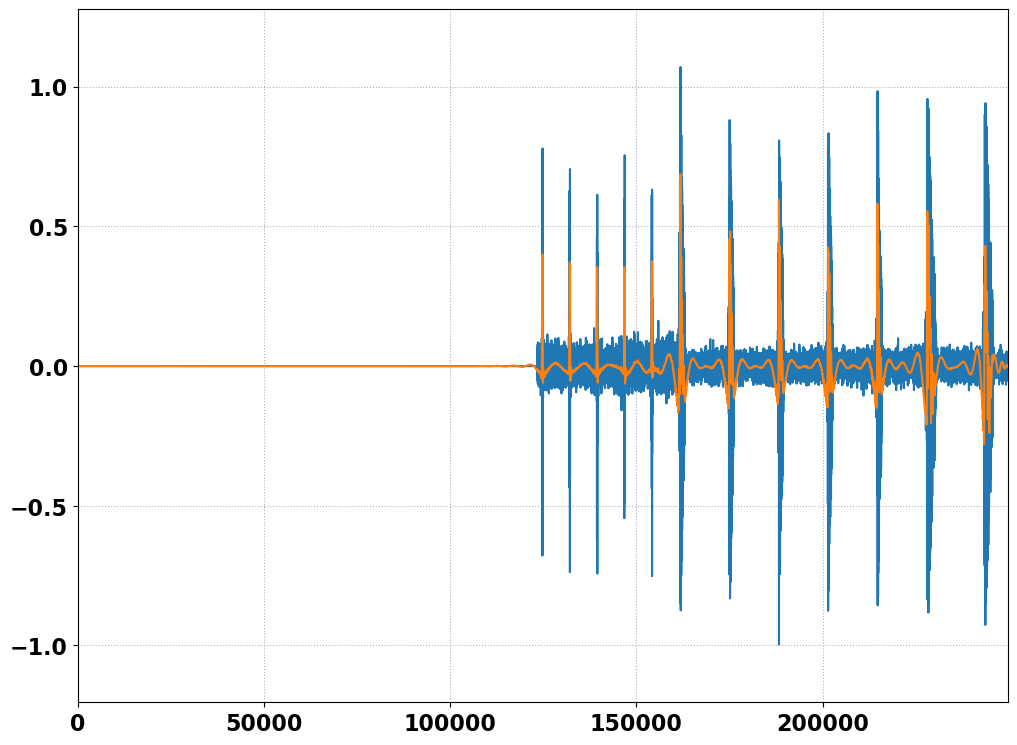

In [11]:
# Get file paths and convert to mono audio
wavlist_N5 = []
wavlist_AB = []

directory_N5 = 'N5DUP_Eclipse_TDOA'
directory_AB = 'AB5YO_Sam_NVIS_TDOA\Eclipse_Day'

for filename in os.listdir(directory_N5):
    f= os.path.join(directory_N5, filename)
    if os.path.isfile(f):
        wavlist_N5.append(f)   

for filename in os.listdir(directory_AB):
    f= os.path.join(directory_AB, filename)
    if os.path.isfile(f):
        wavlist_AB.append(f)

for wavefile in wavlist_N5:
    path  = wavefile
    sound = AudioSegment.from_wav(path)
    sound = sound.set_channels(1)
    sound.export(path, format="wav")
    
for wavefile in wavlist_AB:
    path  = wavefile
    sound = AudioSegment.from_wav(path)
    sound = sound.set_channels(1)
    sound.export(path, format="wav")

# Load sample .wav files
sample_path  = os.path.join('samples','sample7.wav')
sample_env,sample_env_x,sample_fs = process(sample_path)
sample_N5 = sample_env_x

sample_path  = os.path.join('samples','sample8.wav')
sample_env,sample_env_x,sample_fs = process(sample_path)
sample_AB = sample_env_x

plt.plot(wavfile.read(sample_path)[1]/10000)
plt.plot(sample_AB)
# plt.plot(sample_N5)

In [12]:
# Get sidebands and times
year, month, day = 2023, 10, 14
AB_USB, AB_LSB = [], []
N5_USB, N5_LSB = [], []
AB_USB_times, AB_LSB_times = [], []
N5_USB_times, N5_LSB_times = [], []

for i, file in enumerate(wavlist_AB):
    band = file[42:46]
    if band =="_USB": 
        hour = int(wavlist_AB[i][32:34])
        minute = int(wavlist_AB[i][34:36])
        AB_USB.append(i)
        AB_USB_times.append(datetime(year,month,day,hour,minute))
    elif band =="LSB_": 
        hour = int(wavlist_AB[i][32:34])
        minute = int(wavlist_AB[i][34:36])
        AB_LSB.append(i)
        AB_LSB_times.append(datetime(year,month,day,hour,minute))

for i, file in enumerate(wavlist_N5):
    file_path = 'Data and Spreadsheets\\N5DUP Eclipse TDOA\\'+file[-19:]
    with taglib.File(file_path, save_on_exit=True) as file: pass
    band = file.tags['TITLE'][0][39:42]
    if band == 'USB': 
        hour = int(wavlist_N5[i][28:30])
        minute = int(wavlist_N5[i][30:32])
        second = int(wavlist_N5[i][32:34])
        N5_USB.append(i)
        N5_USB_times.append(datetime(year,month,day,hour,minute,second))
    elif band == 'LSB':
        hour = int(wavlist_N5[i][28:30])
        minute = int(wavlist_N5[i][30:32])
        second = int(wavlist_N5[i][32:34])
        N5_LSB.append(i)
        N5_LSB_times.append(datetime(year,month,day,hour,minute,second))

In [13]:
# Find start times
start_times_AB = find_starting_points(sample_AB,wavlist_AB,plot_start=False)
start_times_N5 = find_starting_points(sample_N5,wavlist_N5,plot_start=False)

[4.32572550e-10 6.37016768e-02 1.31758989e-01 1.98936702e-01
 2.65864703e-01 3.32689549e-01 3.99462126e-01 4.66204629e-01
 5.32928260e-01 5.99639277e-01 6.66341449e-01 7.33037181e-01
 7.99728079e-01 8.66415254e-01 9.33099504e-01 9.99781412e-01
 1.06646142e+00 1.13313985e+00 1.19981699e+00 1.26649302e+00
 1.33316811e+00 1.39984240e+00 1.46651600e+00 1.53318900e+00
 1.59986147e+00 1.66653347e+00 1.73320507e+00 1.79987630e+00
 1.86654720e+00 1.93321781e+00 1.99988816e+00 2.06655827e+00
 2.13322817e+00 2.19989787e+00 2.26656739e+00 2.33323675e+00
 2.39990596e+00 2.46657503e+00 2.53324398e+00 2.59991281e+00
 2.66658153e+00 2.73325015e+00 2.79991868e+00 2.86658712e+00
 2.93325548e+00 2.99992376e+00 3.06659198e+00 3.13326013e+00
 3.19992821e+00 3.26659624e+00 3.33326422e+00 3.39993214e+00
 3.46660002e+00 3.53326784e+00 3.59993563e+00 3.66660338e+00
 3.73327108e+00 3.79993875e+00 3.86660639e+00 3.93327399e+00
 3.99994157e+00 4.06660911e+00 4.13327662e+00 4.19994411e+00
 4.26661157e+00 4.333279

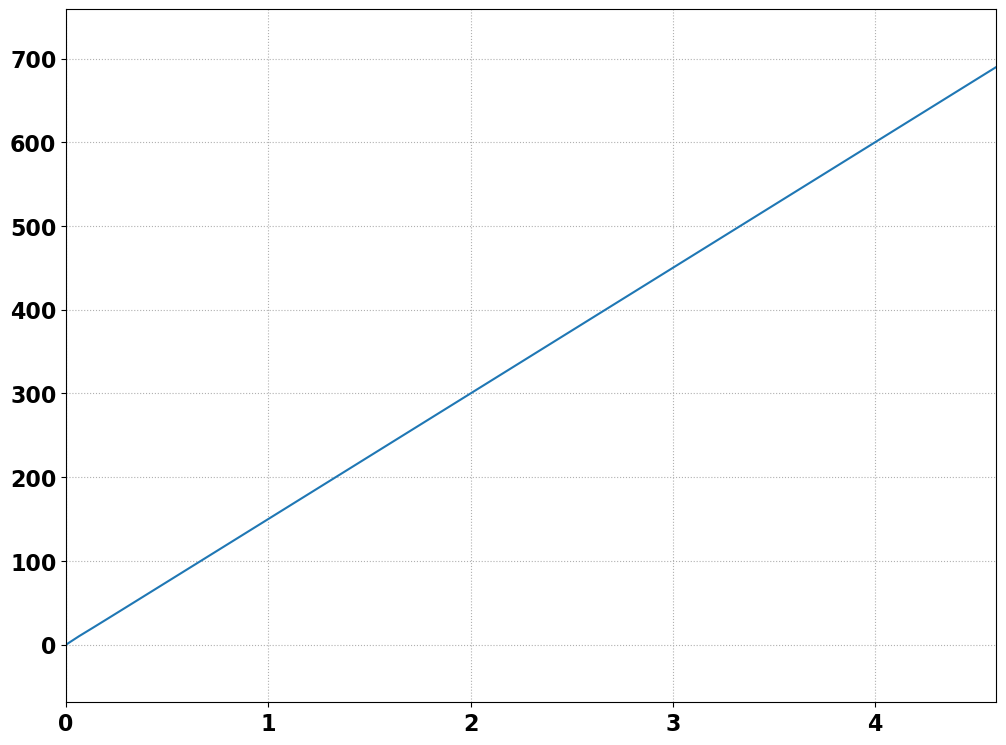

In [14]:
a = np.arange(0,700,10)
b=8.77
c = 2*np.sqrt(2*6378*(6378+a)*(1-np.cos(b/(2*6378)))+a**2)
d = 4*np.sqrt(2*6378*(6378+a)*(1-np.cos(b/(4*6378)))+a**2)
tdoa = (d-c)/300
print(tdoa)
plt.plot(tdoa,a)
print(np.argwhere(a==300))
print(tdoa[25])
print(.6*300/tdoa[25])

In [15]:
# Find beat notes
AB_range_gates = [[-0.01,0.01,1500,3*1500],
                  [0.009,0.03,100, 3*100],
                  [0.005,0.06,50,  3*50],
                  [-0.01,0.15,25,  3*25],
                  [0.025,0.30,10,  3*10]]

N5_range_gates = [[-0.01,0.01,1500,1500*2.5],
                  [0.009,0.03,100 ,100 *2.5],
                  [0.005,0.06,50  ,50  *2.5],
                  [-0.01,0.15,25  ,25  *2.5],
                  [0.025,0.30,10  ,10  *2.5]]

beats_AB = find_beat_notes('AB5YO',wavlist_AB,start_times_AB,AB_range_gates,plot_fft=False)
beats_N5 = find_beat_notes('N5DUP',wavlist_N5,start_times_N5,N5_range_gates,plot_fft=False)

In [21]:
import datetime as dt
import numpy as np

IonosondeLayer_Height = [2.3793333333333336, 2.282, 2.2726666666666667, 2.254, 2.0446666666666666, 2.234, 1.9313333333333333, 2.2506666666666666, 2.2526666666666667, 2.1633333333333333, 2.0753333333333334, 2.0592, 2.078, 1.9926666666666666, 1.8353333333333334, 1.6826666666666666, 1.9366666666666668, 1.8433333333333333, 1.746, 1.7106666666666666, 1.5553333333333334, 1.5753333333333334, 1.684, 1.6513333333333334, 1.6126666666666668, 1.5926666666666666, 1.6273333333333333, 1.5793333333333334, 1.522, 1.548, 1.3853333333333334, 1.4866666666666666, 1.592, 1.6086666666666667, 1.6273333333333333, 1.6146666666666667, 1.62, 1.5226666666666667, 1.602, 1.5686666666666667, 1.4826666666666668, 1.444, 1.6113333333333333, 1.6413333333333333, 1.454, 1.4766666666666666, 1.7166666666666666, 1.5933333333333333, 1.5753333333333334, 1.5966666666666667, 1.5146666666666666, 1.6786666666666667, 1.664, 1.5353333333333334, 1.7413333333333334, 1.9633333333333334, 1.764, 1.6333333333333333, 1.6306666666666667, 1.6566666666666667, 1.6893333333333332, 1.7353333333333334, 1.7553333333333334, 1.81, 1.786, 1.788, 1.7693333333333333, 1.8313333333333334, 1.8386666666666666, 1.8766666666666667, 1.8613333333333334, 1.786, 1.7213333333333334, 1.822, 1.828,1.8366666666666667, 1.708, 1.76, 1.7926666666666667, 1.764, 1.6813333333333333, 1.6926666666666668, 1.742, 1.7506666666666666, 1.6326666666666667, 1.7506666666666666, 1.8893333333333334, 1.914, 1.928, 1.7753333333333334]
Ionosonde_times = [
"11:30", "11:35", "11:40", "11:45", "11:50", "11:55", "12:00", "12:05", "12:10", "12:15", "12:20", "12:25", "12:30", "12:35", "12:40", "12:45", "12:50", "12:55", "13:00", "13:05", "13:10", "13:15", "13:20", "13:25", "13:30", "13:35", "13:40", "13:45", "13:50", "13:55", "14:00", "14:05", "14:10", "14:15", "14:20", "14:25", "14:30", "14:35", "14:40", "14:45", "14:50", "14:55", "15:00", "15:05", "15:10", "15:15", "15:20", "15:25", "15:30", "15:35", "15:40", "15:45", "15:50", "15:55", "16:00", "16:05", "16:10", "16:15", "16:20", "16:25", "16:35", "16:40", "16:45", "16:50", "16:55", "17:00", "17:05", "17:10", "17:15", "17:20", "17:25", "17:30", "17:35", "17:40", "17:45", "17:50", "17:55", "18:00", "18:05", "18:10", "18:15", "18:20", "18:25", "18:30", "18:35", "18:40", "18:45", "18:50", "18:55", "19:00"
]

# Convert strings to datetime objects
# Assuming the date is October 14, 2023
date_str = "2023-10-14"

# Convert each time string to datetime object
Ionosonde_datetimes = [dt.datetime.strptime(date_str + " " + time_str, "%Y-%m-%d %H:%M") for time_str in Ionosonde_times]
print(Ionosonde_datetimes)


[datetime.datetime(2023, 10, 14, 11, 30), datetime.datetime(2023, 10, 14, 11, 35), datetime.datetime(2023, 10, 14, 11, 40), datetime.datetime(2023, 10, 14, 11, 45), datetime.datetime(2023, 10, 14, 11, 50), datetime.datetime(2023, 10, 14, 11, 55), datetime.datetime(2023, 10, 14, 12, 0), datetime.datetime(2023, 10, 14, 12, 5), datetime.datetime(2023, 10, 14, 12, 10), datetime.datetime(2023, 10, 14, 12, 15), datetime.datetime(2023, 10, 14, 12, 20), datetime.datetime(2023, 10, 14, 12, 25), datetime.datetime(2023, 10, 14, 12, 30), datetime.datetime(2023, 10, 14, 12, 35), datetime.datetime(2023, 10, 14, 12, 40), datetime.datetime(2023, 10, 14, 12, 45), datetime.datetime(2023, 10, 14, 12, 50), datetime.datetime(2023, 10, 14, 12, 55), datetime.datetime(2023, 10, 14, 13, 0), datetime.datetime(2023, 10, 14, 13, 5), datetime.datetime(2023, 10, 14, 13, 10), datetime.datetime(2023, 10, 14, 13, 15), datetime.datetime(2023, 10, 14, 13, 20), datetime.datetime(2023, 10, 14, 13, 25), datetime.datetime(2

In [27]:
import datetime 

# Calculate obscuration data
lat_AB =  29.57499
lon_AB = -98.88718

sTime = datetime.datetime(2023,10,14,11,30)
eTime = datetime.datetime(2023,10,14,21,30)
dt    = datetime.timedelta(minutes=1)

eclipse_times = [sTime]
while eclipse_times[-1] < eTime:
    eclipse_times.append(eclipse_times[-1]+dt)

obsc_AB = eclipse_calc.calculate_obscuration(eclipse_times, lat_AB, lon_AB)
#####################
lat_N5 = 30.9
lon_N5 = -99.3

import eclipse_calculator
obsc_N5 = eclipse_calculator.calculate_obscuration(eclipse_times, lat_N5, lon_N5)

solarAB = eclipse_calculator.solarContext.solarTimeseries(sTime,eTime,lat_AB,lon_AB)
solarN5 = eclipse_calculator.solarContext.solarTimeseries(sTime,eTime,lat_N5,lon_N5)

In [36]:
def post_processing(beats,set_name,times,plot_TDOAs=False,solar_val = None, lat = None, lon = None):
    sweep_rates = [1500,1000,50,25,10]
    beat_averages = np.ndarray((len(beats),5))
    rates= [2,3,4]
    
    for i in range(0,len(beat_averages)):
        for j in rates:
            beat_averages[i,j] = np.mean(beats[i,j,:])
    
    avg_across = np.transpose(beat_averages)
    TDOAs = np.ndarray((5,len(beats)))

    for i in rates:
        TDOAs[i,:] = avg_across[i,:]/sweep_rates[i]

    avs = None
    if plot_TDOAs:
        fig = plt.figure(figsize=(15,8))
        ax = fig.add_subplot(1,1,1)

       

        for i in rates:
            ax.scatter(times,TDOAs[i], label=sweep_rates[i])
            ax.plot(times,TDOAs[i],linewidth=.5)

        avs = np.ndarray(((len(np.transpose(TDOAs)),1)))
        for i in range(0 ,len(np.transpose(TDOAs))):
            avs[i] = np.mean(np.transpose(TDOAs)[i,rates])
        avs = avs.flatten()
        ax.plot(times,avs[:], label='avgs', linewidth=3,color="black")
        from datetime import datetime
        ax.set_xlim(datetime(2023,10,14,11,30),datetime(2023,10,14,19,30))
        miny = 0
        maxy = 3
        ax.set_ylim(miny,maxy)
        
        # ax3 = ax.twinx()
        # ax3.yaxis.set_ticks_position("right")
        # ax3.yaxis.set_label_position("right")
        # # ax3.spines["center"].set_position(("axes"))
        # ax3.set_frame_on(True)
        # ax3.patch.set_visible(False)
        # newlabels = np.arange(miny,maxy+.1,.25)
        # ax3.set_yticks(np.arange(0,len(newlabels)))
        # ax3.set_yticklabels((300/2)*newlabels)
        # ax3.ticklabel_format()
        # ax3.set_ylabel('Layer Height [km]')
        
        # print(len(Ionosonde_datetimes))
        # print(len(IonosondeLayer_Height))
        
        
        ax.scatter(Ionosonde_datetimes, IonosondeLayer_Height, color = 'purple')
        ax.plot(Ionosonde_datetimes,IonosondeLayer_Height,label="Austin Ionosonde", color = 'red')
        ax.set_xlim(datetime(2023, 10, 14, 11),datetime(2023, 10, 14, 20, 30))
        
        solar_val.overlaySolarElevation(ax)
        solar_val.overlayEclipse(ax)
        
        # ax2.set_xlabel('Time [UTC]')
        # ax2.set_title('{!s}\N{DEGREE SIGN}N, {!s}\N{DEGREE SIGN}E'.format(lat,lon))

# Format X-Axis Times to HHMM for easier readability.
        xtks    = ax.get_xticks()
        xtk_lbs = []
        for xtk in xtks:
            xtk_dt = mpl.dates.num2date(xtk)
            xtl    = xtk_dt.strftime('%H%M')
            xtk_lbs.append(xtl)
        ax.set_xticks(xtks)
        ax.set_xticklabels(xtk_lbs)
        
        
        


        import matplotlib.dates as mdates
        myFmt = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(myFmt)
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))

        ax.set_ylabel('TDOA [ms]')
        ax.set_xlabel('Time')
        ax.legend()
        ax.set_title(set_name)
        fig.autofmt_xdate()
        plt.tight_layout()
        plt.show()
        plt.close(fig)
    
    return TDOAs,avs

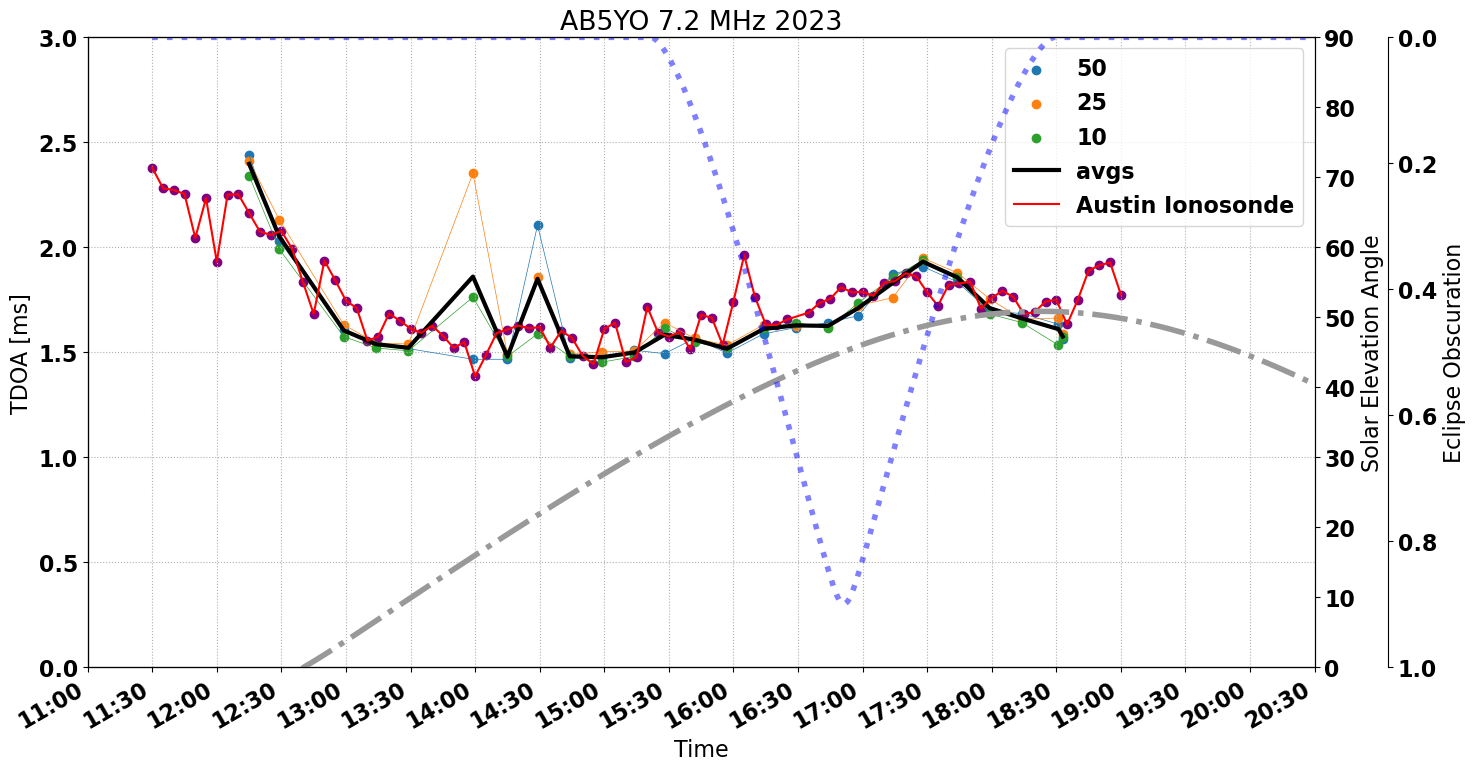

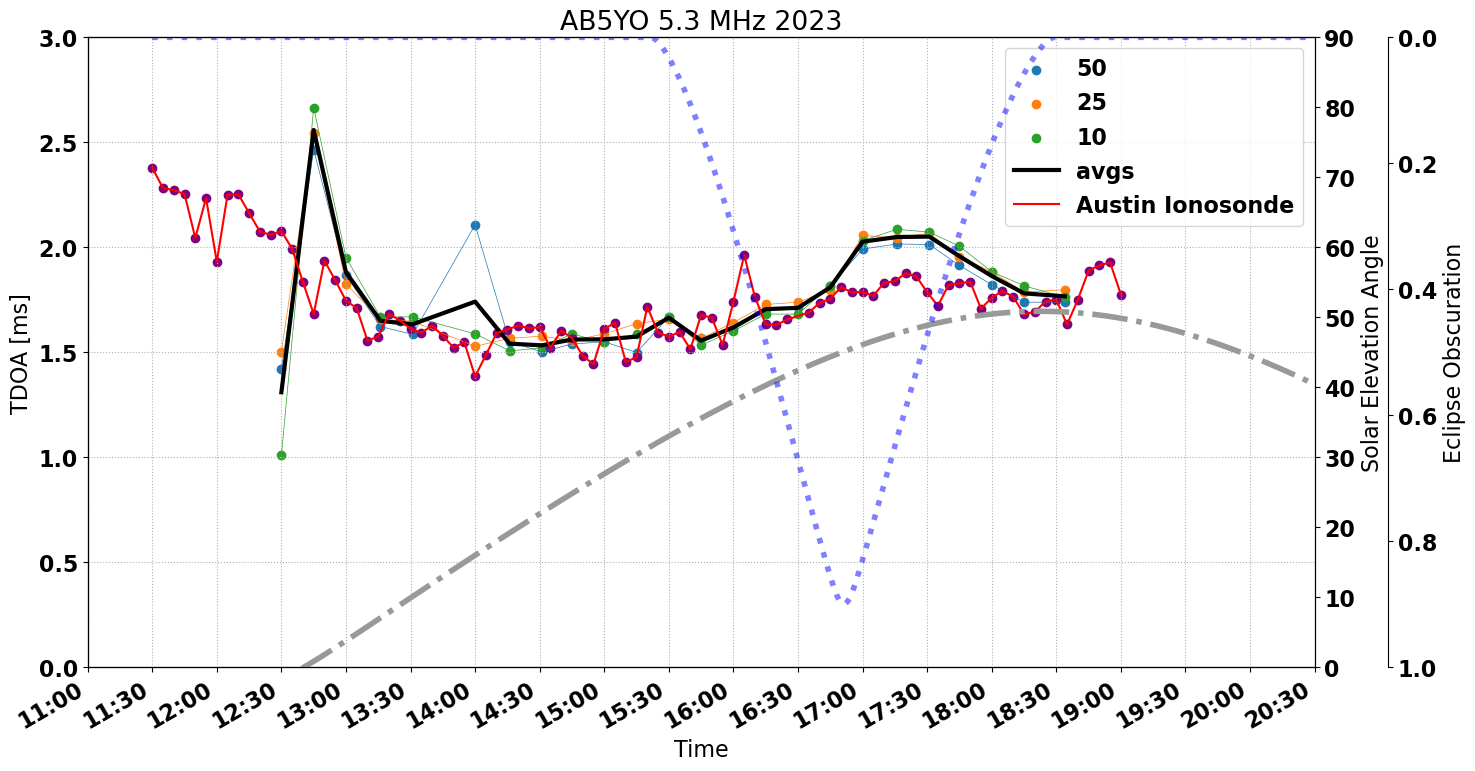

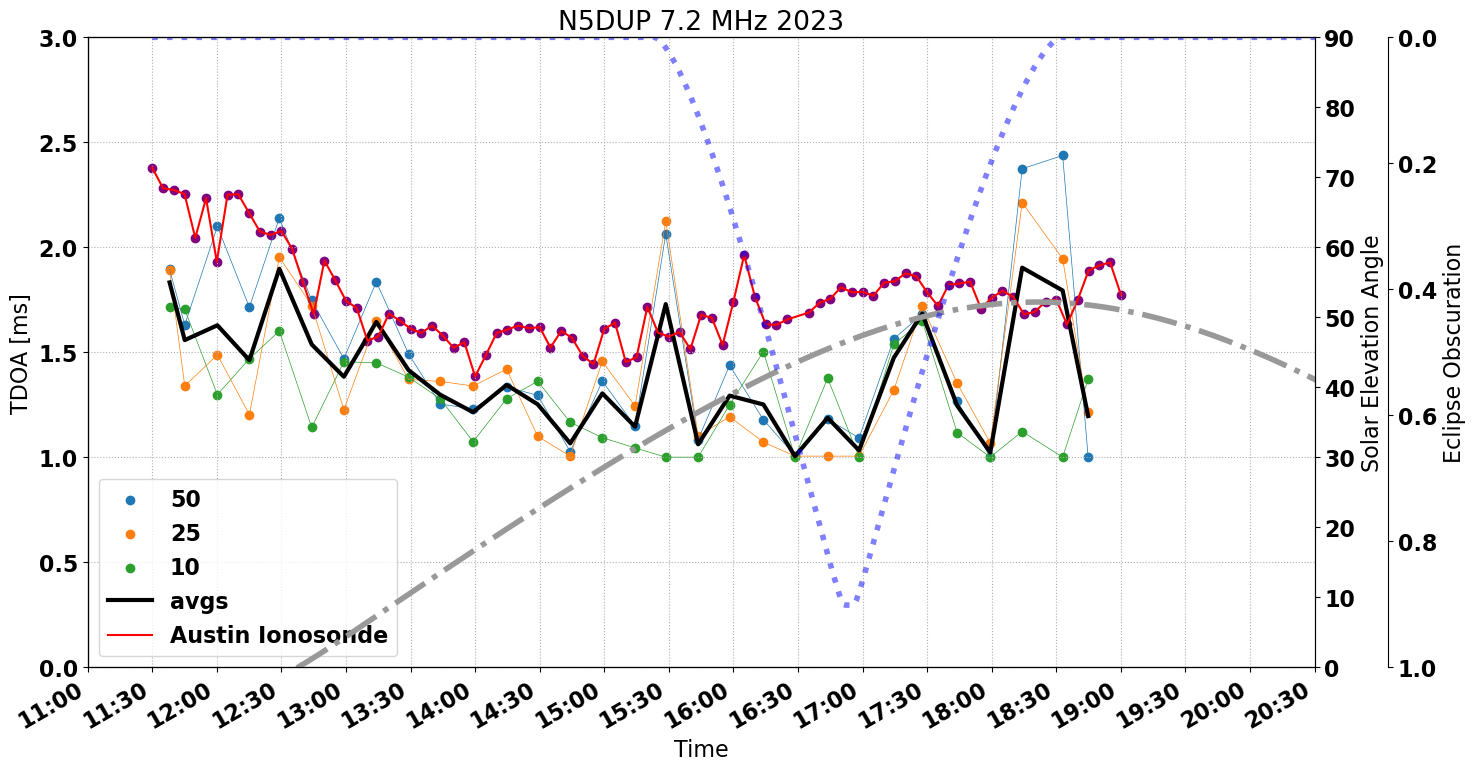

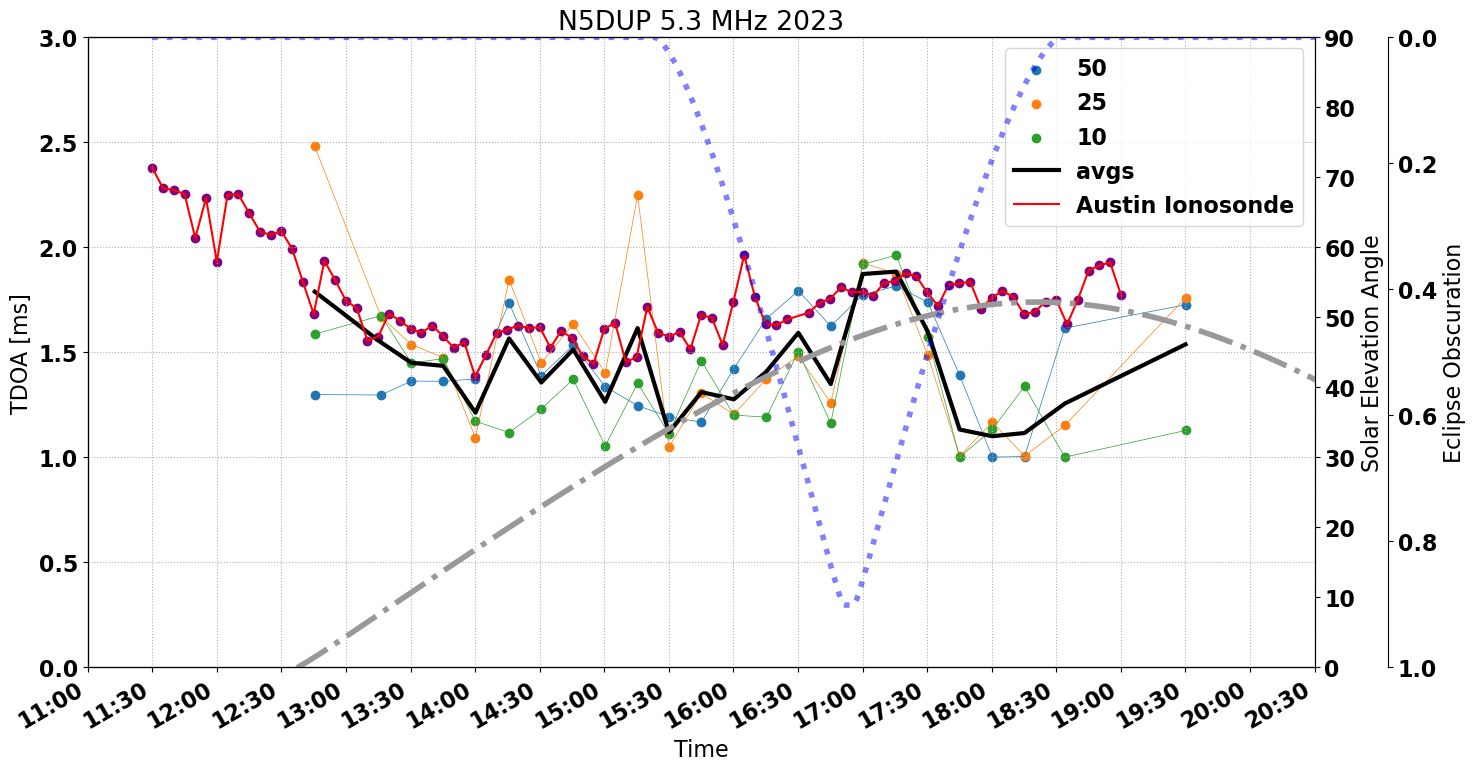

'clear_output(wait=False)\nfig = plt.figure(figsize=(20,16))\nax = fig.add_subplot(2,2,1)\nbx = fig.add_subplot(2,2,2)\ncx = fig.add_subplot(2,2,3)\ndx = fig.add_subplot(2,2,4)\n\nfor i in [0,1,2,3,4]: \n    ax.plot(AB_USB_times,TDOAs_AB_USB[i])\n    bx.plot(AB_LSB_times,TDOAs_AB_LSB[i])\n    cx.plot(N5_USB_times,TDOAs_N5_USB[i])\n    dx.plot(N5_LSB_times,TDOAs_N5_LSB[i])\n'

In [37]:
plot = True
TDOAs_AB_USB,avs1 = post_processing(beats_AB[AB_USB],"AB5YO 7.2 MHz 2023",times=AB_USB_times,plot_TDOAs=plot, solar_val= solarN5, lat = lat_N5, lon = lon_N5)
TDOAs_AB_LSB,avs2 = post_processing(beats_AB[AB_LSB],"AB5YO 5.3 MHz 2023",times=AB_LSB_times,plot_TDOAs=plot, solar_val= solarN5, lat = lat_N5, lon = lon_N5)
TDOAs_N5_USB,avs3 = post_processing(beats_N5[N5_USB],"N5DUP 7.2 MHz 2023",times=N5_USB_times,plot_TDOAs=plot, solar_val= solarAB, lat = lat_AB, lon = lon_AB)
TDOAs_N5_LSB,avs4 = post_processing(beats_N5[N5_LSB],"N5DUP 5.3 MHz 2023",times=N5_LSB_times,plot_TDOAs=plot, solar_val= solarAB, lat = lat_AB, lon = lon_AB)


"""clear_output(wait=False)
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(2,2,1)
bx = fig.add_subplot(2,2,2)
cx = fig.add_subplot(2,2,3)
dx = fig.add_subplot(2,2,4)

for i in [0,1,2,3,4]: 
    ax.plot(AB_USB_times,TDOAs_AB_USB[i])
    bx.plot(AB_LSB_times,TDOAs_AB_LSB[i])
    cx.plot(N5_USB_times,TDOAs_N5_USB[i])
    dx.plot(N5_LSB_times,TDOAs_N5_LSB[i])
"""

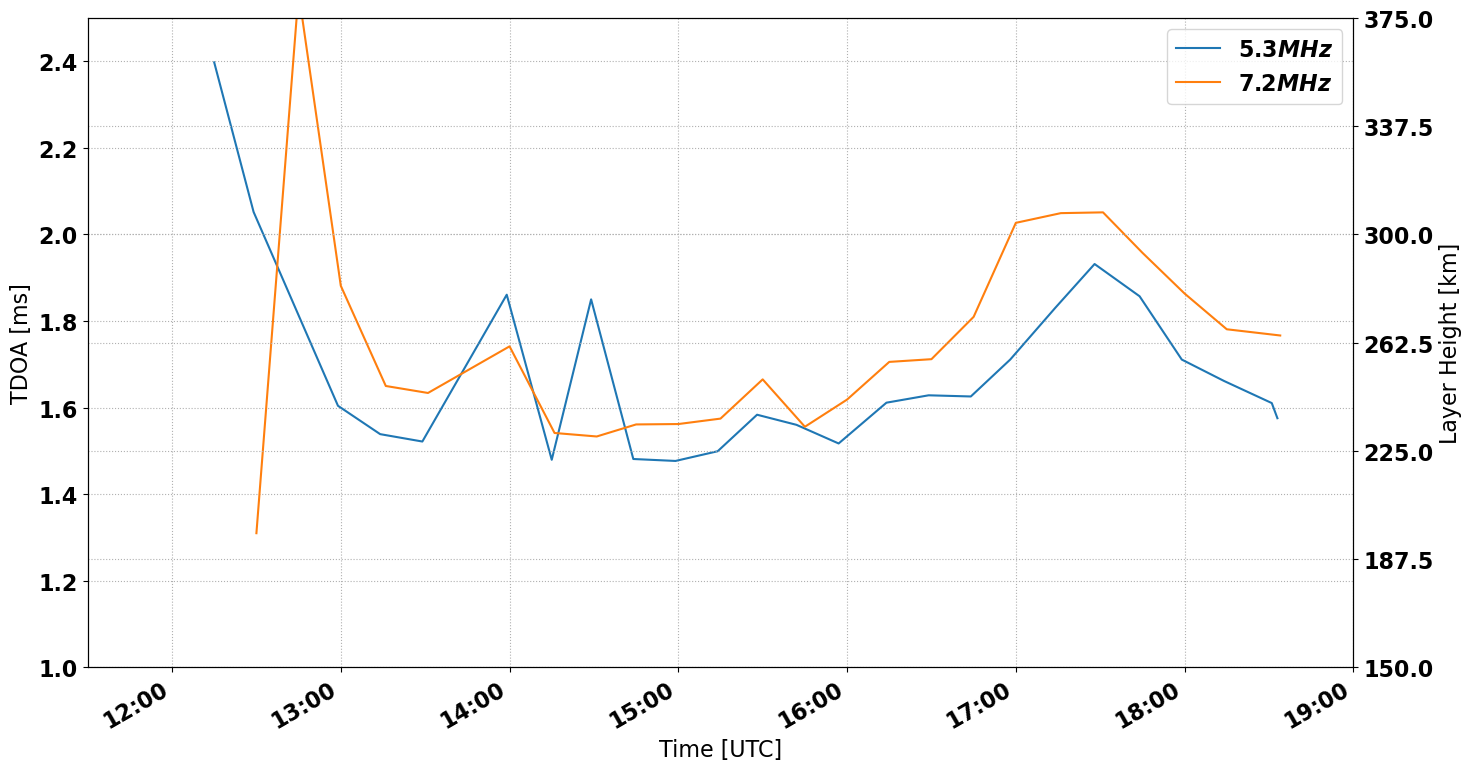

In [19]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1)

ax.plot(AB_USB_times, avs1, label='$5.3 MHz$')
ax.plot(AB_LSB_times, avs2, label='$7.2 MHz$')


ymin = 1
ymax = 2.5
ax.set_ylim(ymin,ymax)
ax.set_xlim(datetime(2023,10,14,11,30),datetime(2023,10,14,19))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))

ax2 = ax.twinx()
newlabels = np.arange(ymin,ymax+.01,.25)
ax2.set_yticks(np.arange(0,len(newlabels)))
ax2.set_yticklabels((300/2)*newlabels)
ax2.set_ylabel('Layer Height [km]')

ax.set_ylabel('TDOA [ms]')
ax.set_xlabel('Time [UTC]')
ax.legend()
# ax.set_title()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
plt.close(fig)

In [20]:
"""sweep_rates = [1500,100,50,25,10]
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)


AB_times = np.concatenate([AB_USB_times,AB_LSB_times])
AB_tdoas = np.concatenate([TDOAs_AB_USB,TDOAs_AB_LSB],axis=1)
#N5_times = np.concatenate([N5_USB_times,N5_LSB_times])
#N5_tdoas = np.concatenate([TDOAs_N5_USB,TDOAs_N5_LSB],axis=1)
#all_tdoas = np.concatenate([TDOAs_AB_USB,TDOAs_AB_LSB,TDOAs_N5_USB,TDOAs_N5_LSB],axis=1)
for i in [0,1,2,3,4]:
    AB_tdoas[i] = [x for _, x in sorted(zip(AB_times, AB_tdoas[i]))]
    #N5_tdoas[i] = [x for _, x in sorted(zip(N5_times, N5_tdoas[i]))]
    #all_tdoas[i] = [x for _, x in sorted(zip(all_times, all_tdoas[i]))]
AB_times = np.sort(AB_times)
#N5_times = np.sort(N5_times)
all_times = np.sort(all_times)

rates= [0,1,2,3,4]
for i in rates:
    ax.scatter(AB_times,AB_tdoas[i], label=sweep_rates[i], color=colors[i])
    ax.plot(AB_times,AB_tdoas[i],linewidth=.5, color=colors[i])

    

    # ax.scatter(N5_times,N5_tdoas[i], label=sweep_rates[i], color=colors[i])
    # ax.plot(N5_times,N5_tdoas[i],linewidth=.5, color=colors[i])

    # ax.scatter(all_times,all_tdoas[i], label=sweep_rates[i], color=colors[i])
    # ax.plot(all_times,all_tdoas[i],linewidth=.5, color=colors[i])

avs = np.ndarray(((len(np.transpose(AB_tdoas)),1)))
for i in range(0 ,len(np.transpose(AB_tdoas))):
    avs[i] = np.mean(np.transpose(AB_tdoas)[i,rates])
avs = avs.flatten()
avs = signal.savgol_filter(avs, 21, 11)
ax.plot(AB_times,avs, label='avgs', linewidth=3,color="black")

ymin = .75
ymax = 2.75
ax.set_ylim(ymin,ymax)
ax.set_xlim(datetime(2023,10,14,11,30),datetime(2023,10,14,19))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))

ax2 = ax.twinx()
newlabels = np.arange(ymin,ymax+.01,.25)
ax2.set_yticks(np.arange(0,len(newlabels)))
ax2.set_yticklabels((300/2)*newlabels)
ax2.set_ylabel('Layer Height [km]')

ax.set_ylabel('TDOA [ms]')
ax.set_xlabel('Time [UTC]')
ax.legend()
# ax.set_title()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
plt.close(fig)"""



'sweep_rates = [1500,100,50,25,10]\ncolors = [u\'#1f77b4\', u\'#ff7f0e\', u\'#2ca02c\', u\'#d62728\', u\'#9467bd\', u\'#8c564b\', u\'#e377c2\', u\'#7f7f7f\', u\'#bcbd22\', u\'#17becf\']\nfig = plt.figure(figsize=(15,8))\nax = fig.add_subplot(1,1,1)\n\n\nAB_times = np.concatenate([AB_USB_times,AB_LSB_times])\nAB_tdoas = np.concatenate([TDOAs_AB_USB,TDOAs_AB_LSB],axis=1)\n#N5_times = np.concatenate([N5_USB_times,N5_LSB_times])\n#N5_tdoas = np.concatenate([TDOAs_N5_USB,TDOAs_N5_LSB],axis=1)\n#all_tdoas = np.concatenate([TDOAs_AB_USB,TDOAs_AB_LSB,TDOAs_N5_USB,TDOAs_N5_LSB],axis=1)\nfor i in [0,1,2,3,4]:\n    AB_tdoas[i] = [x for _, x in sorted(zip(AB_times, AB_tdoas[i]))]\n    #N5_tdoas[i] = [x for _, x in sorted(zip(N5_times, N5_tdoas[i]))]\n    #all_tdoas[i] = [x for _, x in sorted(zip(all_times, all_tdoas[i]))]\nAB_times = np.sort(AB_times)\n#N5_times = np.sort(N5_times)\nall_times = np.sort(all_times)\n\nrates= [0,1,2,3,4]\nfor i in rates:\n    ax.scatter(AB_times,AB_tdoas[i], label=sw

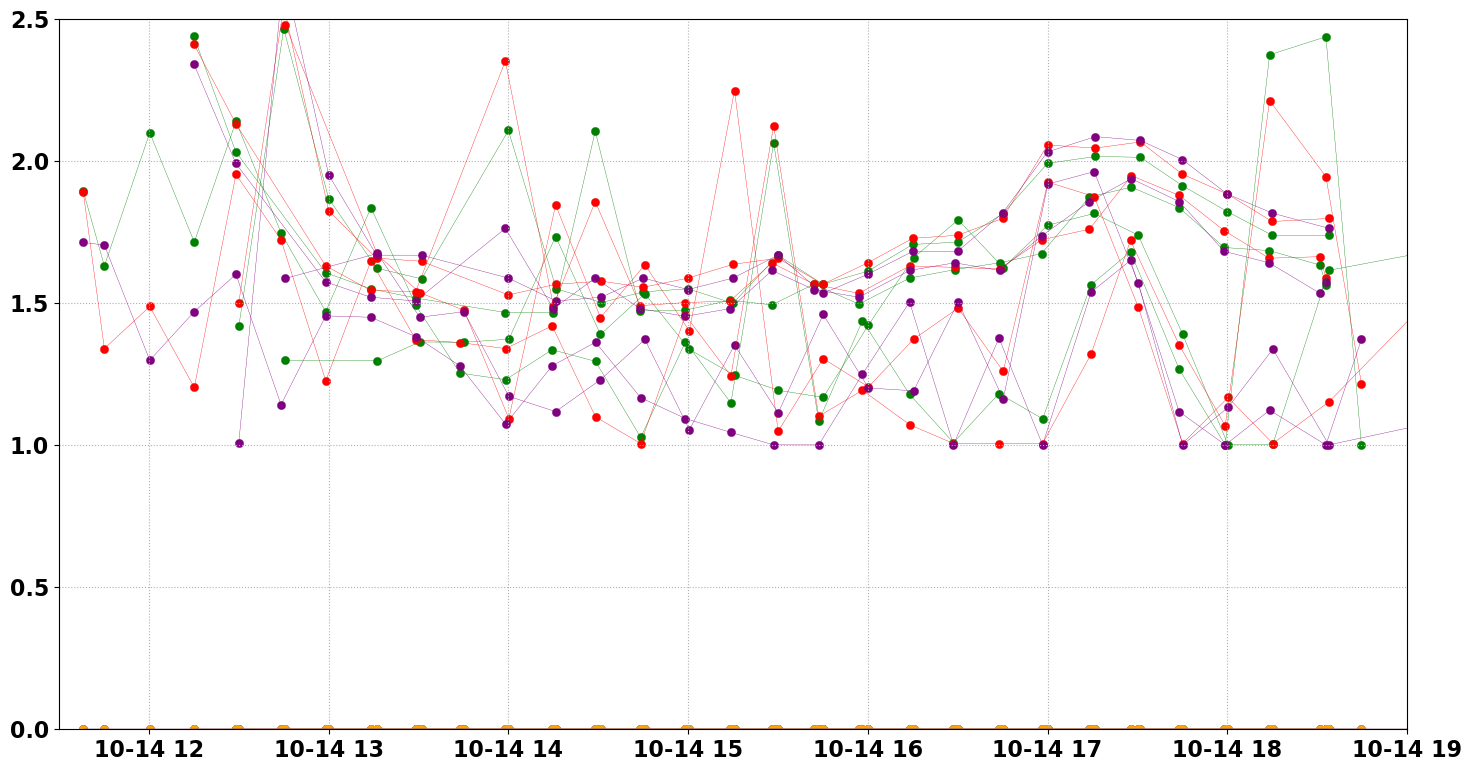

In [21]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
colors = ["blue","orange","green","red","purple"]
for i in [0,1,2,3,4]:
    ax.plot(AB_USB_times,TDOAs_AB_USB[i],label=i,color=colors[i],linewidth=.25)
    ax.plot(AB_LSB_times,TDOAs_AB_LSB[i],label=i,color=colors[i],linewidth=.25)
    ax.plot(N5_USB_times,TDOAs_N5_USB[i],label=i,color=colors[i],linewidth=.25)
    ax.plot(N5_LSB_times,TDOAs_N5_LSB[i],label=i,color=colors[i],linewidth=.25)
for i in [0,1,2,3,4]:
    ax.scatter(AB_USB_times,TDOAs_AB_USB[i],label=i,color=colors[i],linewidth=.25)
    ax.scatter(AB_LSB_times,TDOAs_AB_LSB[i],label=i,color=colors[i],linewidth=.25)
    ax.scatter(N5_USB_times,TDOAs_N5_USB[i],label=i,color=colors[i],linewidth=.25)
    ax.scatter(N5_LSB_times,TDOAs_N5_LSB[i],label=i,color=colors[i],linewidth=.25)
# print(TDOAs_N5_LSB.shape)
TDOAs_AB_USB = np.array(TDOAs_AB_USB)
TDOAs_AB_LSB = np.array(TDOAs_AB_LSB)
TDOAs_N5_USB = np.array(TDOAs_N5_USB)
TDOAs_N5_LSB = np.array(TDOAs_N5_LSB)
arr = ma.empty((5,30,4))
arr.mask = True
arr[:TDOAs_AB_USB.shape[0],:TDOAs_AB_USB.shape[1],0] = TDOAs_AB_USB
arr[:TDOAs_AB_LSB.shape[0],:TDOAs_AB_LSB.shape[1],1] = TDOAs_AB_LSB
arr[:TDOAs_N5_USB.shape[0],:TDOAs_N5_USB.shape[1],2] = TDOAs_N5_USB
arr[:TDOAs_N5_LSB.shape[0],:TDOAs_N5_LSB.shape[1],3] = TDOAs_N5_LSB

# print(np.flip(ma.getmask(arr))[1])
# print(arr.anom(axis=2))


AB_USB_times = np.array(AB_USB_times)
AB_LSB_times = np.array(AB_LSB_times)
N5_USB_times = np.array(N5_USB_times)
N5_LSB_times = np.array(N5_LSB_times)
x_times = ma.empty((5,30,4))
x_times.mask = True
# print(arr)
# arr[:AB_USB_times.shape[0],:AB_USB_times.shape[0],0] = AB_USB_times
# arr[:AB_LSB_times.shape[0],:AB_LSB_times.shape[0],1] = AB_LSB_times
# arr[:N5_USB_times.shape[0],:N5_USB_times.shape[0],2] = N5_USB_times
# arr[:N5_LSB_times.shape[0],:N5_LSB_times.shape[0],3] = N5_LSB_times
# print(AB_USB_times[0])
averages = []
for i in range(0,30):
    averages.append(scipy.stats.trim_mean(arr.mean(axis = 2)[(0,1,2,3,4),i],.0))

# ax.plot(N5_USB_times,arr.mean(axis = 2)[0],color=colors[0],linewidth=2)
# ax.plot(N5_USB_times,arr.mean(axis = 2)[1],color=colors[1],linewidth=2)
# ax.plot(N5_USB_times,arr.mean(axis = 2)[2],color=colors[2],linewidth=2)
# ax.plot(N5_USB_times,arr.mean(axis = 2)[3],color=colors[3],linewidth=2)
# ax.plot(N5_USB_times,arr.mean(axis = 2)[4],color=colors[4],linewidth=2)

# ax.plot(N5_USB_times,averages, linewidth=5, color='black')


ax.set_xlim(datetime(2023,10,14,11,30),datetime(2023,10,14,19))
ax.set_ylim(0,2.5)
# ax.legend()
plt.tight_layout()
plt.show()
plt.close(fig)


In [22]:
# to do
# convert to layer height
# adjust window
# range gating
